In [1]:
import geopandas as gpd
import xarray as xr
from rasterio import features
from affine import Affine
import numpy as np
import salem
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import matplotlib.dates as mdates
import matplotlib.colors as colors
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature


/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# MBNMS Chlorophyll-a #

Monthly surface Chlorophyll-a data ranging from `2002-2019` was collected from the [Coastwatch Thredds server](https://oceanwatch.pfeg.noaa.gov/thredds/Satellite/aggregsatSA/chla/catalog.html).

Data are lazy-loaded (meaning not downloaded into memory) into an xarray dataset wrapped with Salem. A mask is created from a shape file of the sanctuary and a spatial mean is taken for each month, creating a monthly timeseries.

In [ ]:
# client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
# client

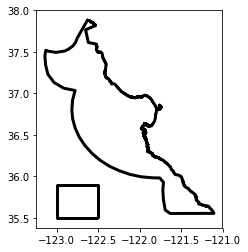

In [2]:
shdf= salem.read_shapefile("./mbnms shapefiles/mbnms_py2/mbnms_py.shp")
bbox = shdf.bounds
shdf.plot(lw=3,edgecolor='k',color='None')

__Lazy load Monthly Modis Chl-a data from Coastwatch Thredds__

This is a global products, so to make it more manageable, the dataset gets split up into the bounding box around the MBNMS.

In [11]:
fname = "https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/satellite/MH1/chla/mday"
fname = "https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/satellite/MW/chla/3day"
dsw = salem.open_xr_dataset(fname)
dsw['lon'] = dsw['lon']-360
dsw = dsw.sel(lat=slice(bbox.miny[0],bbox.maxy[0]),lon=slice(bbox.minx[0],bbox.maxx[0]),altitude=0) # lat goes north to south hear slice(34,32)

Lets do a quick plot to see the first slice of data

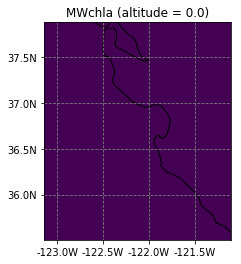

In [13]:
test = dsw['MWchla'].sel(time=slice('2017-06-01','2018-08-01'))
test.mean(dim='time').salem.quick_map()

Now, we want to use the sanctuary shape file to make a mask of the data

In [14]:
dsr = test.salem.roi(shape=shdf)
lons,lats = np.meshgrid(dsr['lon'].values,dsr['lat'].values)

Lets plot the average through time

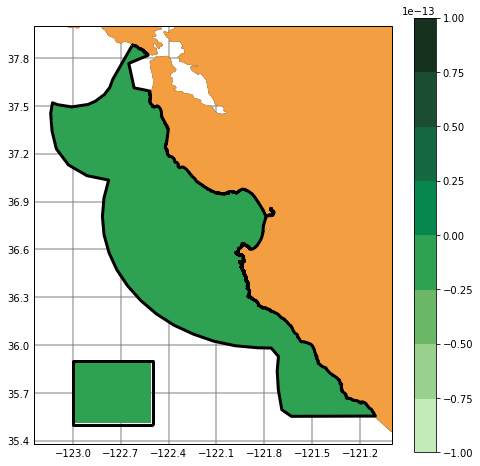

In [15]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='#f49e42'))
cax = ax.contourf(lons,lats,dsr.mean(dim='time'), zorder=2,cmap=cmocean.cm.algae)
shdf.plot(ax=ax,lw=3,edgecolor='k',color='None',zorder=10)
plt.colorbar(cax)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False

__Plot timeseries of spatial mean and median__

In [ ]:
mean_ts = dsr['chlor_a'].mean(dim=['lat','lon'])
sts_ts = dsr['chlor_a'].std(dim=['lat','lon'], ddof=1)
median = mean_ts.median().values
print(median)
mean = mean_ts.mean().values
print(mean)
std = mean_ts.std(ddof=1).values
print(std)

In [ ]:
fig, (ax,ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,6)
mean_ts.plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Chl-a Mean',size=16)
sts_ts.plot(ax=ax2)
ax2.set_ylabel('Chl-a STD',size=16)
ax2.set_xlabel('')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
mean_ts.plot(ax=ax,color='#1a9641')
ax.hlines(mean,mean_ts['time'][0].values,mean_ts['time'][-1].values,label='mean',lw=3)
ax.hlines(mean+std,mean_ts['time'][0].values,mean_ts['time'][-1].values,linestyle='dashed')
ax.hlines(mean-std,mean_ts['time'][0].values,mean_ts['time'][-1].values,linestyle='dashed')
ax.hlines(median,mean_ts['time'][0].values,mean_ts['time'][-1].values,linestyle='dashed',label='median',color='#ca0020',lw=3)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(6))
ax.set_xlabel('')
ax.set_ylabel('Monthly Chl-a')
ax.set_yticks(range(0,10))
plt.legend()

In [ ]:
fig, ax = plt.subplots()
ax.hist(mean_ts,bins=20)

In [ ]:
df = mean_ts.to_pandas()
df = pd.DataFrame(data={'mean':df})
df['year'] = df.index.year
df['month'] = df.index.month
df['cum_sum'] = df.groupby("year")['mean'].cumsum()

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.nanmean(a), stats.sem(a, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def df_ci(series_name, df=df, hour_series):
    """ Return the mean, and 95% confidence intervals """
    ci_mean = []
    ci_lower = []
    ci_upper = []
    for hr in range(1,13):
        v_outer = df[df[hour_series]==hr][series_name]
        ci = mean_confidence_interval(v_outer, confidence=0.95)
        ci_mean.append(ci[0])
        ci_lower.append(ci[1])
        ci_upper.append(ci[2])
    return ci_mean, ci_lower, ci_upper

In [ ]:
mean_ci =  df_ci('cum_sum', df,hour_series='month')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
grouped = df.groupby('year')
for name, group in grouped:
    if name >= 2014:
        ax.plot(group['month'],group['mean'].cumsum(skipna=True),label=name,lw=3)
    else:
        ax.plot(group['month'],group['mean'].cumsum(skipna=True),label='_nolegend_',color='.5',zorder=-1)
# ax.plot(sorted(df['doy'].unique())[:-1],mean_ci[0][:-1],color='k',lw=3)
ax.fill_between(list(range(1,13)),mean_ci[1],mean_ci[2],color='.75')
ax.plot(list(range(1,13)),mean_ci[1],color='.34')
ax.plot(list(range(1,13)),mean_ci[2],color='.34')

ax.plot(list(range(1,13)),mean_ci[0],color='k')
# ax.set_ylim(0)
plt.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(df.groupby('doy')['mean'].mean().cumsum(skipna=True),label='mean')

In [ ]:
fname = "https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/satellite/MH1/chla/mday"
ds = xr.open_dataset(fname)